In [8]:
import json
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy.optimize import curve_fit

from constants import RAW_DIR
from src.model import Asteroid

In [9]:
ASTEROID_NAME = "Pallas"
ASTEROID_ID = 2
PERIOD = 7.81322  # in hours
with open(RAW_DIR / ASTEROID_NAME / "lc.json", "r") as f:
    raw_data = json.load(f)

In [10]:
raw_data[0]

{'LightCurve': {'id': '1',
  'asteroid_id': '101',
  'scale': '0',
  'filter': None,
  'points': '2433827.771536  9.882148e-01    -1.52407483   2.56166596  -1.65498099   -1.37631303   1.55577772  -1.65510792\n2433827.773953  9.665995e-01    -1.52409281   2.56165996  -1.65497547   -1.37629054   1.55577761  -1.65510240\n2433827.783286  9.621180e-01    -1.52416223   2.56163678  -1.65495417   -1.37620371   1.55577719  -1.65508110\n2433827.790454  9.550239e-01    -1.52421554   2.56161898  -1.65493781   -1.37613703   1.55577688  -1.65506473\n2433827.795662  9.479908e-01    -1.52425428   2.56160604  -1.65492593   -1.37608857   1.55577666  -1.65505285\n2433827.803037  9.470855e-01    -1.52430913   2.56158772  -1.65490909   -1.37601996   1.55577637  -1.65503601\n2433827.809745  9.357856e-01    -1.52435902   2.56157106  -1.65489378   -1.37595756   1.55577612  -1.65502070\n2433827.816038  9.280344e-01    -1.52440582   2.56155543  -1.65487942   -1.37589902   1.55577589  -1.65500633\n2433827.822538

In [11]:
asteroid = Asteroid.from_lightcurves(
    id=ASTEROID_ID,  # Where to get this id from?
    name=ASTEROID_NAME,
    period=PERIOD,
    data=raw_data
)
asteroid

Asteroid(id=2, name=Pallas, period=7.81322, lightcurves=61)

In [12]:
asteroid.lightcurves[14]

LightCurve(id=15, scale=0, points=[Point(time=datetime.datetime(1968, 3, 13, 21, 37, 26, 400000), brightness=1.001199, x_sun=2.25520779, y_sun=-0.25084041, z_sun=-0.00423429, x_earth=1.26665533, y_earth=-0.14399141, z_earth=-0.00422968), Point(time=datetime.datetime(1968, 3, 13, 21, 46, 4, 800000), brightness=1.007701, x_sun=2.25522589, y_sun=-0.25078169, z_sun=-0.00427632, x_earth=1.26666066, y_earth=-0.14403571, z_earth=-0.00427172), Point(time=datetime.datetime(1968, 3, 13, 21, 50, 24), brightness=1.013299, x_sun=2.25523495, y_sun=-0.25075233, z_sun=-0.00429734, x_earth=1.26666333, y_earth=-0.14405786, z_earth=-0.00429275), Point(time=datetime.datetime(1968, 3, 13, 21, 53, 16, 800000), brightness=1.017985, x_sun=2.25524098, y_sun=-0.25073276, z_sun=-0.00431135, x_earth=1.26666511, y_earth=-0.14407263, z_earth=-0.00430676), Point(time=datetime.datetime(1968, 3, 13, 22, 0, 28, 800000), brightness=1.026481, x_sun=2.25525606, y_sun=-0.25068382, z_sun=-0.00434638, x_earth=1.26666956, y_e

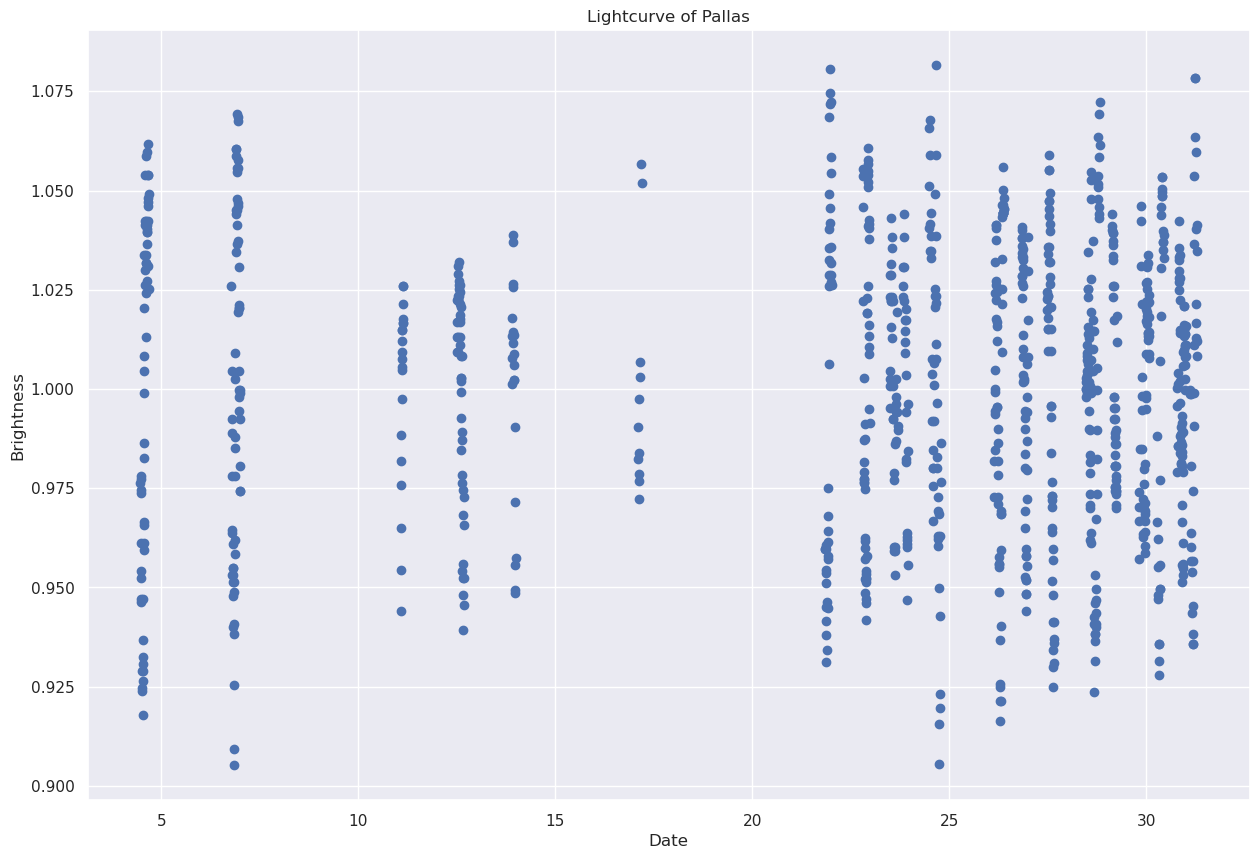

In [13]:
asteroid.plot_lc_by_dates(0, 20)

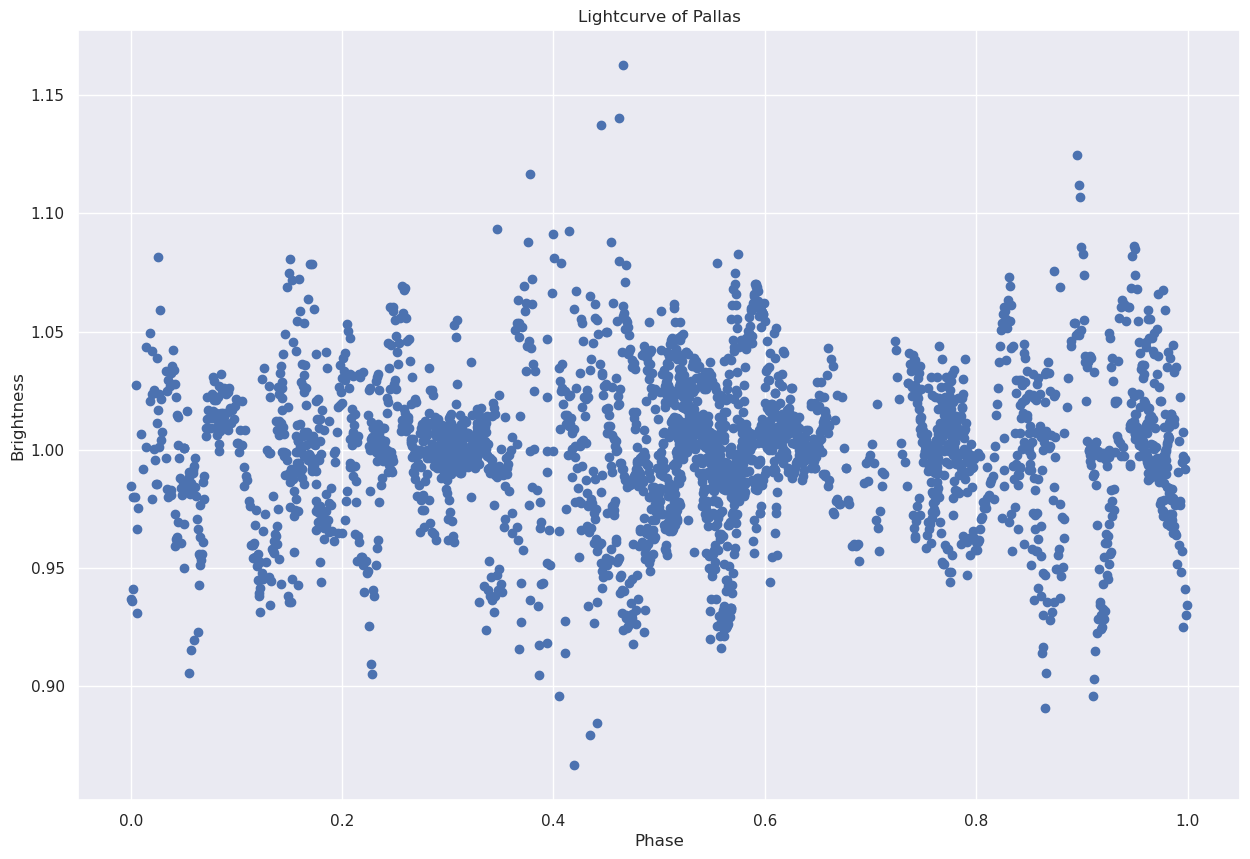

In [14]:
phases, brightnesses = asteroid.plot_lightcurves()

In [15]:
step = 0.01
end = 1 + step
bin_edges = np.arange(0, end, step)
bin_edges

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [16]:
bins = np.digitize(phases, bin_edges)
bins

array([86, 86, 86, ..., 62, 62, 62])

In [17]:
phase_bins = {}
brightness_bins = {}

for b, (phase, bright) in zip(bins, zip(phases, brightnesses)):
    if b in brightness_bins:
        brightness_bins[b].append(bright)
        phase_bins[b].append(phase)
    else:
        brightness_bins[b] = [bright]
        phase_bins[b] = [phase]

In [18]:
mean_phases = []
mean_brightnesses = []

for b in sorted(brightness_bins.keys()):
    mean_phases.append(np.mean(phase_bins[b]))
    mean_brightnesses.append(np.mean(brightness_bins[b]))

In [19]:
len(phases), len(brightnesses)

(2926, 2926)

In [20]:
len(mean_phases), len(mean_brightnesses)


(100, 100)

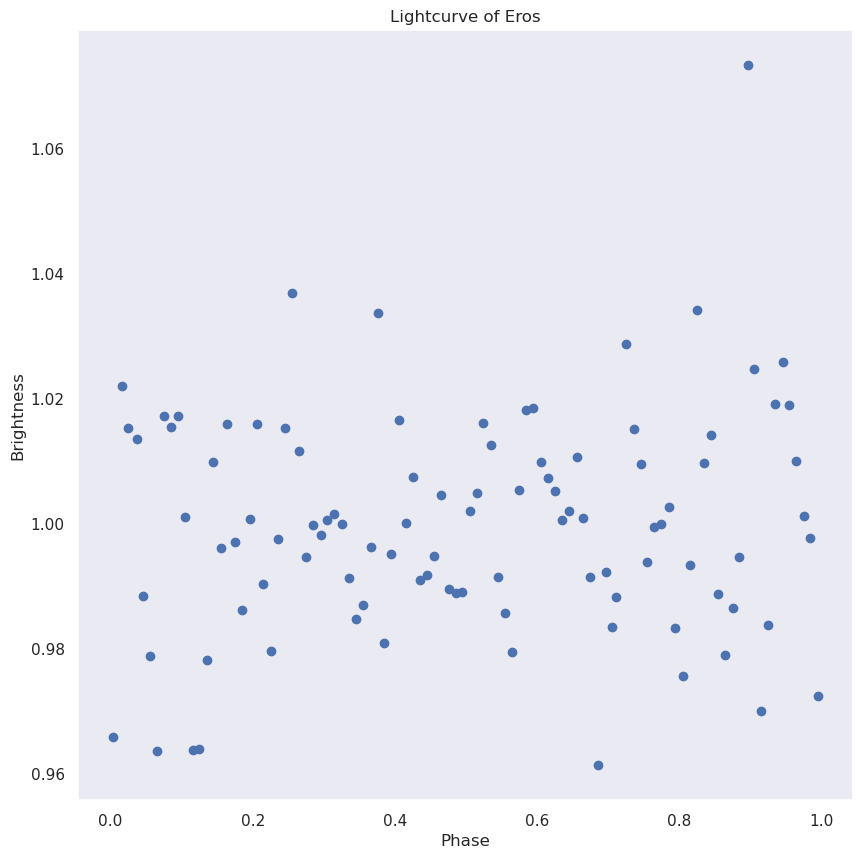

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(mean_phases, mean_brightnesses)
ax.set_xlabel("Phase")
ax.set_ylabel("Brightness")
ax.set_title("Lightcurve of Eros")
ax.grid()
plt.show()


In [37]:
def fourier_series(x, *a):
    reconstruction = a[0]
    an = a[1::2]
    bn = a[2::2]
    for i in range(len(an)):
        freq = 2 * np.pi * (i + 1)
        reconstruction += an[i] * np.cos(freq * x) + bn[i] * np.sin(freq * x)

    return reconstruction


N = 36
params = [0.1] * 2 * N
initial_guess = [np.mean(brightnesses), *params]

In [38]:
phases = np.array(phases)
brightnesses = np.array(brightnesses)

In [39]:
# sort the phases and brightnesses by phase
idx = np.argsort(phases)
phases = phases[idx]
brightnesses = brightnesses[idx]

In [40]:
popt, pcov = curve_fit(f=fourier_series, xdata=phases, ydata=brightnesses, p0=initial_guess)

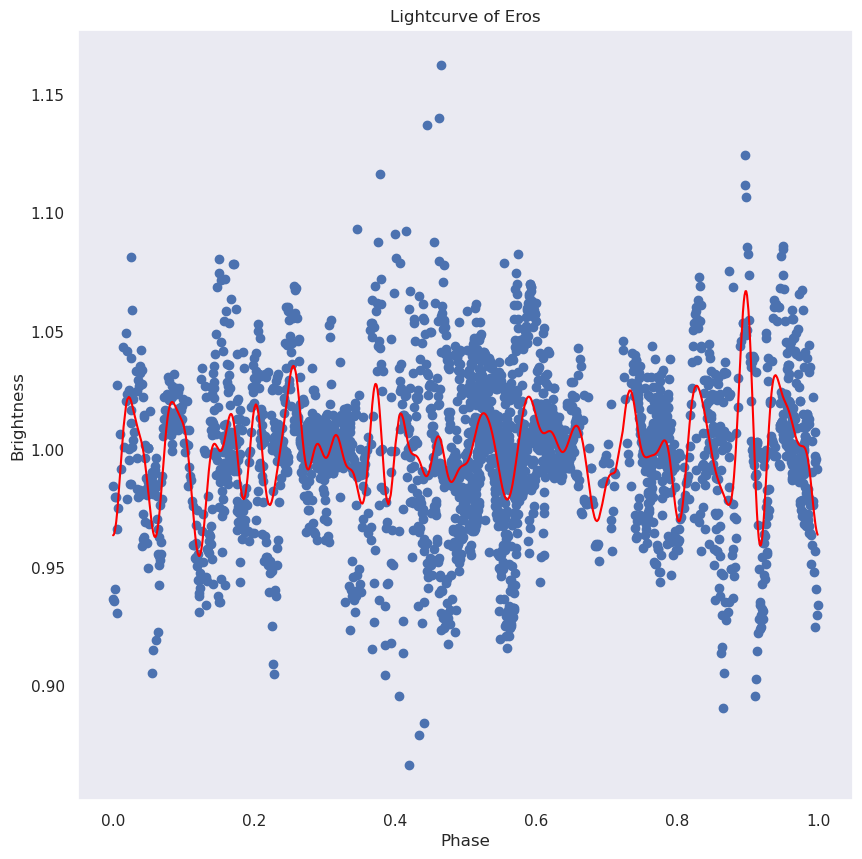

In [41]:
fitted_curve = fourier_series(np.array(phases), *popt)

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(phases, brightnesses)
ax.plot(phases, fitted_curve, color="red")
ax.set_xlabel("Phase")
ax.set_ylabel("Brightness")
ax.set_title("Lightcurve of Eros")
ax.grid()

plt.show()